<a href="https://colab.research.google.com/github/Viswonathan06/Al-DDoS-Attack-Detector/blob/main/Generating_Recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import time
import pathlib
import os
from google.colab import drive
import requests
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
file_url = "http://data.csail.mit.edu/im2recipe/recipes_with_nutritional_info.json"

r = requests.get(file_url, stream = True)  
  
#change this according ur file extension
with open("/content/gdrive/My Drive/recipes.json", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

In [ ]:
pathlib.Path('./Data').mkdir(exist_ok=True)

In [102]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

def load_dataset(silent=False):
    # List of dataset files we want to merge.
    dataset_file_names = ['recipes.json']
    #/content/gdrive/MyDrive/recipes.json
    dataset = []
    for dataset_file_name in dataset_file_names:
        dataset_file_path = f'/content/gdrive/MyDrive/{dataset_file_name}'
        with open(dataset_file_path) as dataset_file:
            json_data_list = json.load(dataset_file)
            # print(json_data_dict.)
            # json_data_list = list(json_data_dict.values())
            dict_keys = [key for key in json_data_list[0]]
            dict_keys.sort()
            dataset += json_data_list
    #         # This code block outputs the summary for each dataset.
            if silent == False:
                print(dataset_file_path)
                print('===========================================')
                print('Number of examples: ', len(json_data_list), '\n')
                print('Example object keys:\n', dict_keys, '\n')
                print('Example object:\n', json_data_list[10], '\n')
                print('Required keys:\n')
                print('  title: ', json_data_list[10]['title'], '\n')
                print('  ingredients: ', json_data_list[10]['ingredients'], '\n')
                print('  instructions: ', json_data_list[10]['instructions'])
                print('\n\n')
    return dataset  
dataset_raw = load_dataset()

/content/gdrive/MyDrive/recipes.json
Number of examples:  51235 

Example object keys:
 ['fsa_lights_per100g', 'id', 'ingredients', 'instructions', 'nutr_per_ingredient', 'nutr_values_per100g', 'partition', 'quantity', 'title', 'unit', 'url', 'weight_per_ingr'] 

Example object:
 {'fsa_lights_per100g': {'fat': 'red', 'salt': 'orange', 'saturates': 'orange', 'sugars': 'green'}, 'id': '000982e226', 'ingredients': [{'text': 'squash, winter, butternut, raw'}, {'text': 'cauliflower, raw'}, {'text': 'broccoli, raw'}, {'text': 'nuts, walnuts, english'}, {'text': 'nuts, almonds'}, {'text': 'seeds, sunflower seed kernels, dried'}, {'text': 'salt, table'}, {'text': 'spices, cumin seed'}, {'text': 'spices, pepper, black'}, {'text': 'oil, olive, salad or cooking'}], 'instructions': [{'text': 'Place a steamer insert into a saucepan and fill with water to just below the bottom of the steamer.'}, {'text': 'Bring water to a boil.'}, {'text': 'Add butternut squash cubes, cover, and steam until tender, 

In [103]:
print('Total number of raw examples: ', len(dataset_raw))
def recipe_validate_required_fields(recipe):
    required_keys = ['title', 'ingredients', 'instructions']
    
    if not recipe:
        return False
    
    for required_key in required_keys:
        if not recipe[required_key]:
            return False
        
        if type(recipe[required_key]) == list and len(recipe[required_key]) == 0:
            return False
    
    return True

Total number of raw examples:  51235


In [104]:
dataset_validated = [recipe for recipe in dataset_raw if recipe_validate_required_fields(recipe)]

In [105]:
STOP_WORD_TITLE = '!!RECIPE!! '
STOP_WORD_INGREDIENTS = '\nINGREDIENTS!!\n\n'
STOP_WORD_INSTRUCTIONS = '\n!!INSTRUCTIONS!!\n\n'

In [106]:
def recipe_to_string(recipe):
    title = recipe['title']
    ingredients = recipe['ingredients']
    instructions = recipe['instructions']
    
    ingredients_string = ''
    for ingredient in ingredients:
        string = ingredient['text']+" "
        if ingredient:
            ingredients_string += f'#{string}\n'
    # print(ingredients_string)
    
    instructions_string = ''
    for instruction in instructions:
        string = instruction['text']+" "
        if instruction:
            instructions_string += f'**{string}\n'
    
    return f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'

In [107]:
dataset_stringified = [recipe_to_string(recipe) for recipe in dataset_validated]
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  51235


In [108]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe {}\n'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe 1

!!RECIPE!! Yogurt Parfaits

INGREDIENTS!!

#yogurt, greek, plain, nonfat 
#strawberries, raw 
#cereals ready-to-eat, granola, homemade 

!!INSTRUCTIONS!!

**Layer all ingredients in a serving dish. 



Recipe 2

!!RECIPE!! Salt Free, Low Cholesterol Sugar Cookies Recipe

INGREDIENTS!!

#sugars, granulated 
#oil, corn, peanut, and olive 
#egg substitute, powder 
#orange juice, raw 
#orange juice, raw 
#leavening agents, baking powder, double-acting, sodium aluminum sulfate 
#wheat flour, white, all-purpose, unenriched 

!!INSTRUCTIONS!!

**Cream sugar and butter together till smooth. 
**Add in egg beaters, orange rind, orange juice, and mix well. 
**Mix together low sodium baking powder and flour. 
**Add in to creamed mix and mix well. 
**Roll dough into 1 inch balls and place on ungreased cookie sheet. 
**Rub small amount of salt free butter on bottom of glass. 
**Dip glass in granulated sugar. 
**Flatten cookie dough ball slightly using flat end of glass. 
**Bake at 300 degr

### RNN is taking too much time for long strings, so filtering it for strings more than 3000 characters in length


In [109]:
MAX_RECIPE_LENGTH = 3000
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 
dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]
print('Dataset size before - ', len(dataset_stringified))
print('New size - ', len(dataset_filtered))
TOTAL_RECIPES_NUM = len(dataset_stringified)
print('Maximum length of string: ', MAX_RECIPE_LENGTH)


Dataset size before -  51235
New size -  51019
Maximum length of string:  3000


In [110]:
STOP_SIGN = '␣'
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)
# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.fit_on_texts(dataset_filtered)
tokenizer.get_config()
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  98


In [111]:
array_vocabulary = tokenizer.sequences_to_texts([[word_index] 
                                                 for word_index in range(VOCABULARY_SIZE)])
print([char for char in array_vocabulary])

['', ' ', 'e', 'a', 't', 'o', 'r', 'i', 'n', 's', 'l', '\n', 'd', 'u', 'h', 'c', '*', ',', 'p', 'm', 'g', '!', 'w', 'b', 'f', '.', '#', 'I', 'k', 'y', 'v', 'S', 'E', 'N', 'T', 'R', 'C', 'P', '1', 'x', '-', 'D', 'O', 'G', '0', '2', 'U', 'B', '3', '5', 'A', ')', '(', 'j', 'M', 'z', 'F', '4', '/', 'W', '6', 'q', ';', 'L', '8', ':', "'", 'H', '9', '%', '7', 'Y', '"', 'K', 'V', '&', 'J', 'Q', 'Z', 'X', '?', '~', ']', '[', '=', '+', '_', '@', '$', '}', '{', '`', '>', '^', '<', '|', '\\', '␣']


In [112]:
tokenizer.texts_to_sequences([' yes'])
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)
print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 51019


In [113]:
print(dataset_vectorized[0][:10], '...')


[21, 21, 35, 32, 36, 27, 37, 32, 21, 21] ...


In [114]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)
recipe_sequence_to_string(dataset_vectorized[0])

! ! R E C I P E ! !   Y o g u r t   P a r f a i t s 
 
 I N G R E D I E N T S ! ! 
 
 # y o g u r t ,   g r e e k ,   p l a i n ,   n o n f a t   
 # s t r a w b e r r i e s ,   r a w   
 # c e r e a l s   r e a d y - t o - e a t ,   g r a n o l a ,   h o m e m a d e   
 
 ! ! I N S T R U C T I O N S ! ! 
 
 * * L a y e r   a l l   i n g r e d i e n t s   i n   a   s e r v i n g   d i s h .   



In [115]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 199
Recipe #2 length: 798
Recipe #3 length: 1143
Recipe #4 length: 566
Recipe #5 length: 685
Recipe #6 length: 436
Recipe #7 length: 445
Recipe #8 length: 1393
Recipe #9 length: 1457
Recipe #10 length: 810


In [139]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 3001
Recipe #1 length: 3001
Recipe #2 length: 3001
Recipe #3 length: 3001
Recipe #4 length: 3001
Recipe #5 length: 3001
Recipe #6 length: 3001
Recipe #7 length: 3001
Recipe #8 length: 3001
Recipe #9 length: 3001


In [117]:
recipe_sequence_to_string(dataset_vectorized_padded[0])


! ! R E C I P E ! !   Y o g u r t   P a r f a i t s 
 
 I N G R E D I E N T S ! ! 
 
 # y o g u r t ,   g r e e k ,   p l a i n ,   n o n f a t   
 # s t r a w b e r r i e s ,   r a w   
 # c e r e a l s   r e a d y - t o - e a t ,   g r a n o l a ,   h o m e m a d e   
 
 ! ! I N S T R U C T I O N S ! ! 
 
 * * L a y e r   a l l   i n g r e d i e n t s   i n   a   s e r v i n g   d i s h .   
 ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ 

In [118]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
print(dataset)

<TensorSliceDataset shapes: (3001,), types: tf.int32>


In [119]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())
recipe

Raw recipe:
 [21 21 35 ... 97 97 97] 



Stringified recipe:

! ! R E C I P E ! !   Y o g u r t   P a r f a i t s 
 
 I N G R E D I E N T S ! ! 
 
 # y o g u r t ,   g r e e k ,   p l a i n ,   n o n f a t   
 # s t r a w b e r r i e s ,   r a w   
 # c e r e a l s   r e a d y - t o - e a t ,   g r a n o l a ,   h o m e m a d e   
 
 ! ! I N S T R U C T I O N S ! ! 
 
 * * L a y e r   a l l   i n g r e d i e n t s   i n   a   s e r v i n g   d i s h .   
 ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ ␣ 

<tf.Tensor: shape=(3001,), dtype=int32, numpy=array([21, 21, 35, ..., 97, 97, 97], dtype=int32)>

In [140]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text
dataset_targeted = dataset.map(split_input_target)
print(dataset_targeted)

<MapDataset shapes: ((3000,), (3000,)), types: (tf.int32, tf.int32)>


In [141]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 3000
Target sequence size: 3000

Input:   '! ! R E C I P E ! !   Y o g u r t   P a r f a i t s \n \n I N G R E D I E N T S ! ! \n \n # y o g u r t'
Target:  '! R E C I P E ! !   Y o g u r t   P a r f a i t s \n \n I N G R E D I E N T S ! ! \n \n # y o g u r t ,'


In [142]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 21 ('!')
  expected output: 21 ('!')
Step  2
  input: 21 ('!')
  expected output: 35 ('R')
Step  3
  input: 35 ('R')
  expected output: 32 ('E')
Step  4
  input: 32 ('E')
  expected output: 36 ('C')
Step  5
  input: 36 ('C')
  expected output: 27 ('I')
Step  6
  input: 27 ('I')
  expected output: 37 ('P')
Step  7
  input: 37 ('P')
  expected output: 32 ('E')
Step  8
  input: 32 ('E')
  expected output: 21 ('!')
Step  9
  input: 21 ('!')
  expected output: 21 ('!')
Step 10
  input: 21 ('!')
  expected output: 1 (' ')


In [143]:
print(dataset_targeted)


<MapDataset shapes: ((3000,), (3000,)), types: (tf.int32, tf.int32)>


In [144]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  51235
MAX_RECIPE_LENGTH:  3000
VOCABULARY_SIZE:  98


In [145]:
# Batch size.
BATCH_SIZE = 64
# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
SHUFFLE_BUFFER_SIZE = 1000
dataset_train = dataset_targeted \
  .shuffle(SHUFFLE_BUFFER_SIZE) \
  .batch(BATCH_SIZE, drop_remainder=True) \
  .repeat()
print(dataset_train)

<RepeatDataset shapes: ((64, 3000), (64, 3000)), types: (tf.int32, tf.int32)>


In [146]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[21 21 35 ... 97 97 97]
 [21 21 35 ... 97 97 97]
 [21 21 35 ... 97 97 97]
 ...
 [21 21 35 ... 97 97 97]
 [21 21 35 ... 97 97 97]
 [21 21 35 ... 97 97 97]], shape=(64, 3000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[21 35 32 ... 97 97 97]
 [21 35 32 ... 97 97 97]
 [21 35 32 ... 97 97 97]
 ...
 [21 35 32 ... 97 97 97]
 [21 35 32 ... 97 97 97]
 [21 35 32 ... 97 97 97]], shape=(64, 3000), dtype=int32)


In [147]:
tmp_vocab_size = 10
tmp_embedding_size = 5
tmp_input_length = 8
tmp_batch_size = 2
tmp_model = tf.keras.models.Sequential()
tmp_model.add(tf.keras.layers.Embedding(
  input_dim=tmp_vocab_size,
  output_dim=tmp_embedding_size,
  input_length=tmp_input_length
))

tmp_input_array = np.random.randint(
  low=0,
  high=tmp_vocab_size,
  size=(tmp_batch_size, tmp_input_length)
)
tmp_model.compile('rmsprop', 'mse')
tmp_output_array = tmp_model.predict(tmp_input_array)
print('tmp_input_array shape:', tmp_input_array.shape)
print('tmp_input_array:')
print(tmp_input_array)
print()
print('tmp_output_array shape:', tmp_output_array.shape)
print('tmp_output_array:')
print(tmp_output_array)

tmp_input_array shape: (2, 8)
tmp_input_array:
[[7 9 1 7 9 0 0 1]
 [7 8 3 2 8 2 5 5]]

tmp_output_array shape: (2, 8, 5)
tmp_output_array:
[[[-0.01864772  0.02723273  0.03525596 -0.03733705  0.04094695]
  [-0.03328965  0.04493095 -0.03252818  0.00448693 -0.04574161]
  [ 0.00288135  0.04952189 -0.03756946 -0.02228519 -0.0073278 ]
  [-0.01864772  0.02723273  0.03525596 -0.03733705  0.04094695]
  [-0.03328965  0.04493095 -0.03252818  0.00448693 -0.04574161]
  [ 0.00286107  0.02651043  0.03750343 -0.00098336 -0.01154695]
  [ 0.00286107  0.02651043  0.03750343 -0.00098336 -0.01154695]
  [ 0.00288135  0.04952189 -0.03756946 -0.02228519 -0.0073278 ]]

 [[-0.01864772  0.02723273  0.03525596 -0.03733705  0.04094695]
  [ 0.03473957 -0.03401263  0.03767503 -0.04396163 -0.04233776]
  [-0.04677231  0.03058844 -0.03672336  0.03158906 -0.03261484]
  [-0.02112745 -0.02150466 -0.03593466  0.00129358  0.04929203]
  [ 0.03473957 -0.03401263  0.03767503 -0.04396163 -0.04233776]
  [-0.02112745 -0.02150466 

In [148]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))
    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))
    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model
model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=512,
  batch_size=BATCH_SIZE
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (64, None, 256)           25088     
_________________________________________________________________
lstm_4 (LSTM)                (64, None, 512)           1574912   
_________________________________________________________________
dense_4 (Dense)              (64, None, 98)            50274     
Total params: 1,650,274
Trainable params: 1,650,274
Non-trainable params: 0
_________________________________________________________________


In [149]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 3000, 98) # (batch_size, sequence_length, vocab_size)


In [150]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-4.5995614e-03 -1.8075964e-03 -2.5441318e-03  1.7342314e-03
  1.7331903e-03  3.5774005e-03 -1.8703656e-03 -3.4651570e-03
 -2.4229868e-03 -2.5823747e-03  6.1292159e-03  8.2589267e-03
 -5.3454745e-03 -3.4052595e-03  8.6705666e-03 -5.5469794e-04
 -1.0678928e-03  2.8224234e-03 -7.5081275e-03  2.4368258e-03
  1.8392751e-03 -1.3979960e-03 -4.5319381e-03  8.0073928e-04
  4.6525658e-03 -7.7931387e-03 -1.1125908e-03 -1.5449001e-03
 -3.8654308e-03  1.3398204e-03  6.1053559e-03  2.3740507e-03
  3.0621018e-03 -4.0814131e-03  5.7529286e-03  7.0150802e-04
  4.4043125e-03 -2.5611110e-03 -4.2395699e-03  7.3689665e-04
  6.6422126e-03 -6.0897036e-03 -6.7192186e-03 -2.2908805e-03
 -2.8273666e-03 -5.6981007e-03 -1.7293785e-03 -6.7119231e-03
  3.1198526e-04 -2.4841039e-03  6.7337486e-04 -6.0117166e-03
 -2.3703852e-03  2.1489053e-03  1.6382708e-03  2.7603994e-03
  1.3814332e-03 -4.9526072e-03 -3.4270764e-03 -2.4532436e-03
 -1.4656574e-03 -

In [151]:
tmp_logits = [
  [-0.95, 0, 0.95],
];

tmp_samples = tf.random.categorical(
    logits=tmp_logits,
    num_samples=5
)
print(tmp_samples)

tf.Tensor([[2 2 2 1 1]], shape=(1, 5), dtype=int64)


In [152]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)
sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()
sampled_indices.shape

(3000,)

In [153]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:100]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:100]]))))

Input:
 '! ! R E C I P E ! !   S o r b e t   - -   N o   I c e   C r e a m   M a k e r   N e e d e d ! \n \n I N G R E D I E N T S ! ! \n \n # s t r a w b e r r i e s ,   r a w   \n # y o g u r t ,   v a n i l l a'

Next char prediction:
 'j j ! h A 4 { w s l z   ~ z x | g I ^ i U p | i . 8 N ; > m s : 4 6 \' O H   O + ~ J # , 9 ␣ p < / L S m . A U i \\ i J } m ^ c 5 j S n 7 4 # . A V & } H : \n A M ~ ] ; z 6 p ^ y l v c E S L = " N R'


In [154]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

In [155]:
model.compile( optimizer=tf.keras.optimizers.RMSprop(),loss=loss)

In [157]:
# Directory to save the model
chkpnt_dir = '/content/gdrive/MyDrive'
os.makedirs(chkpnt_dir, exist_ok=True)
chkpnt_pref = os.path.join(chkpnt_dir, 'ckpt_{epoch}')
chkpnt_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=chkpnt_pref,
    save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)


In [158]:
EPOCHS = 10
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 500
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH
)

Epoch 2/10
500/500 [==============================] - 407s 810ms/step - loss: 0.8736
Epoch 3/10
500/500 [==============================] - 409s 817ms/step - loss: 0.2387
Epoch 4/10
500/500 [==============================] - 408s 816ms/step - loss: 0.1747
Epoch 5/10
500/500 [==============================] - 408s 817ms/step - loss: 0.1545
Epoch 6/10
500/500 [==============================] - 409s 818ms/step - loss: 0.1459
Epoch 7/10
500/500 [==============================] - 408s 815ms/step - loss: 0.1415
Epoch 8/10
500/500 [==============================] - 408s 816ms/step - loss: 0.1362
Epoch 9/10
500/500 [==============================] - 408s 815ms/step - loss: 0.1339
Epoch 10/10
500/500 [==============================] - 410s 819ms/step - loss: 0.1321


In [159]:
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

In [173]:
checkpoint_dir="/content/gdrive/MyDrive"
os.listdir(checkpoint_dir)
model_name = 'recipe.h5'
model.save(model_name, save_format='h5')

# print(tf.train.latest_checkpoint(checkpoint_dir))
# /content/recipe_generation_rnn_raw.h5

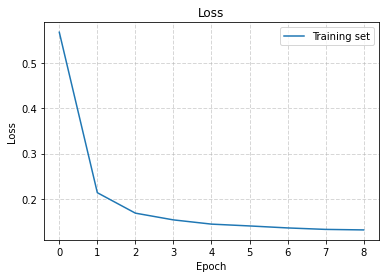

In [161]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

In [162]:

def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    # Evaluation step (generating text using the learned model)
    padded_start_string = STOP_WORD_TITLE + start_string
    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))
    # Empty string to store our results.
    text_generated = []
    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()
        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]
        text_generated.append(next_character)
    return (padded_start_string + ''.join(text_generated))

In [170]:
def generate_combinations(model):
    recipe_length = 1000
    try_letters = ['Salt', 'Vinegar', 'C', 'O', 'L', 'Mushroom', 'Apple', 'Slow', 'Onion', 'Banana', '']
    try_temperature = [1.0, 0.8, 0.4, 0.2]
    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
            print(f'Attempt: "{letter}" + {temperature}')
            print('-----------------------------------')
            print(generated_text)
            print('\n\n')

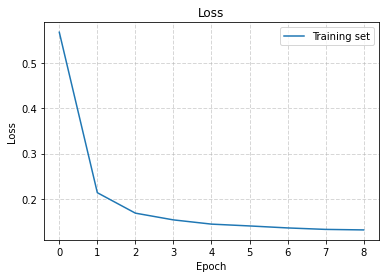

In [164]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()
render_training_history(history)

In [171]:
simplified_batch_size = 1
checkpoint_dir = "/content/recipe_generation_rnn.h5"
model_simplified = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=512,
  batch_size=simplified_batch_size)
model_simplified.load_weights(checkpoint_dir)
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))
model_simplified.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (1, None, 256)            25088     
_________________________________________________________________
lstm_9 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
dense_9 (Dense)              (1, None, 98)             50274     
Total params: 1,650,274
Trainable params: 1,650,274
Non-trainable params: 0
_________________________________________________________________


In [172]:
generate_combinations(model_simplified)


Attempt: "Salt" + 1.0
-----------------------------------
!!RECIPE!! Salts

INGREDIENTS!!

#beans, snap, green, raw 
#water, bottled, generic 
#salt, table 
#sauce, ready-to-serve, pepper, table 
#spices, pepper, red or cayenne 
#oil, olive, salad or cooking 
#butter, without salt 
#spices, poppy seed 
#beef, grass-fed, ground, raw 
#oil, corn, peanut, and olive 
#oil, olive, salad or cooking 
#sauerkraut, salt, bakeril 
#cheese, cheddar 
#vanilla extract 

!!INSTRUCTIONS!!

**Add butter in a microwave safe bowl. 
**Blend for in refrigerator. 
**Recipe from chicken meltzo refinitilly. 
␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣

KeyboardInterrupt: ignored